Avg. Area Income                0
Avg. Area House Age             0
Avg. Area Number of Rooms       0
Avg. Area Number of Bedrooms    0
Area Population                 0
Price                           0
Address                         0
dtype: int64
Best parameters for Random Forest: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 20}
Tuned Random Forest - Mean Squared Error: 14382578984.076033
Tuned Random Forest - R2 Score: 0.8780399039863893
Ridge Regression - Mean Squared Error: 10412314055.15691
Ridge Regression - R2 Score: 0.9117065984273901
Lasso Regression - Mean Squared Error: 10412431070.676064
Lasso Regression - R2 Score: 0.9117056061697452
Stacking Ensemble - Mean Squared Error: 10425101562.199614
Stacking Ensemble - R2 Score: 0.9115981640785553


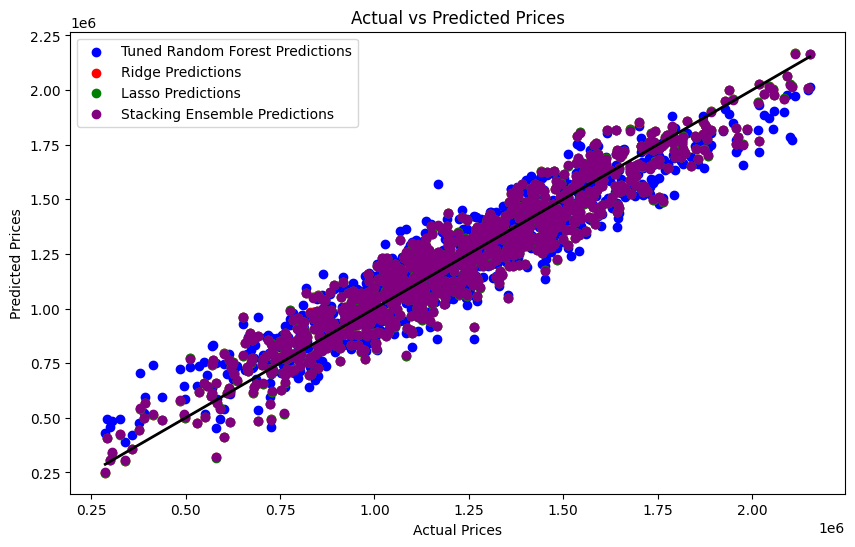

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

# Load the dataset
house = pd.read_csv("dataset/USA_Housing.csv")

# Check for missing values
print(house.isnull().sum())

# Drop the 'Address' column as it is not useful for prediction
house = house.drop(['Address'], axis=1)

# Define features and target variable
X = house.drop(['Price'], axis=1)
y = house["Price"]

# Outlier detection and removal
Q1 = house.quantile(0.25)
Q3 = house.quantile(0.75)
IQR = Q3 - Q1
house = house[~((house < (Q1 - 1.5 * IQR)) | (house > (Q3 + 1.5 * IQR))).any(axis=1)]

# Define features and target variable again after outlier removal
X = house.drop(['Price'], axis=1)
y = house["Price"]

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature engineering using Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_poly = poly.fit_transform(X_scaled)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor with RandomizedSearchCV
rf = RandomForestRegressor(random_state=42)
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

# Best parameters from RandomizedSearchCV
best_params_rf = rf_random.best_params_
print(f"Best parameters for Random Forest: {best_params_rf}")

# Train the model with the best parameters
rf_best = RandomForestRegressor(**best_params_rf, random_state=42)
rf_best.fit(X_train, y_train)

# Make predictions with the tuned Random Forest
y_pred_rf_best = rf_best.predict(X_test)

# Evaluate the tuned Random Forest model
mse_rf_best = mean_squared_error(y_test, y_pred_rf_best)
r2_rf_best = r2_score(y_test, y_pred_rf_best)

print(f"Tuned Random Forest - Mean Squared Error: {mse_rf_best}")
print(f"Tuned Random Forest - R2 Score: {r2_rf_best}")

# Initialize and train the Ridge and Lasso regression models
ridge = Ridge()
lasso = Lasso()

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

# Make predictions with Ridge and Lasso
y_pred_ridge = ridge.predict(X_test)
y_pred_lasso = lasso.predict(X_test)

# Evaluate the Ridge and Lasso models
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Ridge Regression - Mean Squared Error: {mse_ridge}")
print(f"Ridge Regression - R2 Score: {r2_ridge}")

print(f"Lasso Regression - Mean Squared Error: {mse_lasso}")
print(f"Lasso Regression - R2 Score: {r2_lasso}")

# Model ensemble using Stacking
estimators = [
    ('rf', rf_best),
    ('ridge', ridge),
    ('lasso', lasso)
]
stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking_regressor.fit(X_train, y_train)

# Make predictions with the stacking ensemble
y_pred_stacking = stacking_regressor.predict(X_test)

# Evaluate the stacking ensemble model
mse_stacking = mean_squared_error(y_test, y_pred_stacking)
r2_stacking = r2_score(y_test, y_pred_stacking)

print(f"Stacking Ensemble - Mean Squared Error: {mse_stacking}")
print(f"Stacking Ensemble - R2 Score: {r2_stacking}")

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf_best, color='blue', label='Tuned Random Forest Predictions')
plt.scatter(y_test, y_pred_ridge, color='red', label='Ridge Predictions')
plt.scatter(y_test, y_pred_lasso, color='green', label='Lasso Predictions')
plt.scatter(y_test, y_pred_stacking, color='purple', label='Stacking Ensemble Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()